In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

sns.set_palette('deep') # does not work
sns.set()

#from druglib import df_o, df_num
from autocorrect import Speller
import nltk
import nltk.tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from textblob import TextBlob

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB

In [80]:
%store -r df_o
%store -r df_num

# Text data

### Preprocessing functions

In [5]:
def create_word_cloud(df, column_name):     
    text = df[column_name].values 
    wordcloud = WordCloud(width=700, height=700, background_color='white', 
                          min_font_size=10).generate(str(text))
    plt.figure(figsize=(5,5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

column_reviews = ['benefitsReview', 'sideEffectsReview', 'commentsReview']

In [6]:
"""import scispacy
import spacy
from scispacy.linking import EntityLinker
from spacy import displacy
import en_core_sci_sm"""

'import scispacy\nimport spacy\nfrom scispacy.linking import EntityLinker\nfrom spacy import displacy\nimport en_core_sci_sm'

In [7]:
"""nlp = spacy.load('en_core_sci_sm')
txt = 'sinus infection'
doc = nlp(txt)

nlp.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 3}) # add entity linker -long loadtime

linker = nlp.get_pipe("scispacy_linker")                            

fmt_str = "{:<20}| {:<10}| {:<32}| {:<20}"
print(fmt_str.format("Entity", "1st CUI", "Canonical Name", "Definition"))

doc.ents

for entity in doc.ents:
    first_cuid = entity._.kb_ents[0][0]
    kb_entry = linker.kb.cui_to_entity[first_cuid]
    print(fmt_str.format(entity.text, first_cuid, kb_entry.canonical_name, kb_entry.definition[0:15] + "..."))

displacy_image = displacy.render(doc, jupyter = True, style = "dep")
print(list(doc.sents))"""

'nlp = spacy.load(\'en_core_sci_sm\')\ntxt = \'sinus infection\'\ndoc = nlp(txt)\n\nnlp.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 3}) # add entity linker -long loadtime\n\nlinker = nlp.get_pipe("scispacy_linker")                            \n\nfmt_str = "{:<20}| {:<10}| {:<32}| {:<20}"\nprint(fmt_str.format("Entity", "1st CUI", "Canonical Name", "Definition"))\n\ndoc.ents\n\nfor entity in doc.ents:\n    first_cuid = entity._.kb_ents[0][0]\n    kb_entry = linker.kb.cui_to_entity[first_cuid]\n    print(fmt_str.format(entity.text, first_cuid, kb_entry.canonical_name, kb_entry.definition[0:15] + "..."))\n\ndisplacy_image = displacy.render(doc, jupyter = True, style = "dep")\nprint(list(doc.sents))'

In [443]:
def get_sentiments(df, column_name):
    polarity = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity
    df['polarity_'+column_name] = df[column_name].apply(polarity)
    df['subjectivity_'+column_name] = df[column_name].apply(sub)
    return df

def create_sentiments(df, column_name):
    df = get_sentiments(df, column_name)
    df = df[['polarity_benefitsReview', 'subjectivity_benefitsReview', 
    'polarity_sideEffectsReview', 'subjectivity_sideEffectsReview', 
    'polarity_commentsReview', 'subjectivity_commentsReview']]
    return df   

* Remove no, not, less, and more from stop words since they have important meaning in expressions of benefits/sideEffects

In [82]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
ENGLISH_STOP_WORDS = set( stopwords.words('english') ).union(set(ENGLISH_STOP_WORDS))
#print(ENGLISH_STOP_WORDS)
ENGLISH_STOP_WORDS.remove('no')
ENGLISH_STOP_WORDS.remove('not')
ENGLISH_STOP_WORDS.remove('less')
ENGLISH_STOP_WORDS.remove('more')
ENGLISH_STOP_WORDS.add('mg')

stop_words= ENGLISH_STOP_WORDS

* Remove drug names, correct spelling (not done), get_bag of words

In [239]:
def remove_drug_names(df, column_name):
    drug_names = list(df['urlDrugName'].unique())                                                   
    df[column_name] = df[column_name].astype('str').str.lower()
    new_reviews=[]
    for i, row in df.iterrows():
        review = row[column_name]
        for drug in drug_names:
            review = review.replace(drug, 'drug_name')
        new_reviews.append(review)
    df[column_name] = new_reviews
    return df

def correct_spelling(df, column_name):                                                                 # not used
    check = Speller(lang='en')
    df_t = df.copy()
    df_t[column_name] = df_t[column_name].map(lambda cell: check(cell))
    return df_t

def get_bag_of_words(df, column_name, min, max):
    df[column_name] = df[column_name].str.replace(r'\d+','')
    vec = CountVectorizer(ngram_range=(min, max), stop_words=stop_words, max_features=10000).fit(df[column_name])        
    bag_of_words = vec.transform(df[column_name])                                                                #tuple of numbers (0, 2980) 1
    return vec, bag_of_words                                                                

* Get term frequency (tf) and inverse document frequency (idf)

In [ ]:
def create_bow_df(bow):             
    vec, count_matrix = bow[-1]                     # allReviews only
    count_array = count_matrix.toarray()
    df_bow = pd.DataFrame(data=count_array, columns=vec.get_feature_names())
    return df_bow

In [ ]:
def get_tf_idf(bow, tf_or_idf=True):
    bow_df = create_bow_df(bow)
    vect = TfidfTransformer(use_idf=tf_or_idf).fit(bow_df)
    tf_matrix = vect.transform(bow_df) #df_bow
    tf_array = tf_matrix.toarray()
    df_tfx = pd.DataFrame(data=tf_array, columns=vect.get_feature_names_out())
    return df_tfx

##### 1. Remove drug names and merge review column

In [256]:
# PREPROCESS DATA
df_no_drugs = df_text.copy()
column_reviews = ['benefitsReview', 'sideEffectsReview', 'commentsReview']
for review in column_reviews:
    df_no_drugs = remove_drug_names(df_no_drugs, review)
    #df_no_drugs = correct_spelling(df_no_drugs, review)            #~60 mins

df_no_drugs['allReviews'] = df_no_drugs['benefitsReview'] + df_no_drugs['sideEffectsReview'] + df_no_drugs['commentsReview']
column_reviews.append('allReviews')

##### 2. get bag of words

In [257]:
# bag of words for presentation                     #4 reviews, benefits, sideeffects, comments, all
df_bows_1 = df_no_drugs.copy()
bows_1 = [get_bag_of_words(df_no_drugs, review, 1, 1) for review in column_reviews]
bows_2 = [get_bag_of_words(df_no_drugs, review, 2, 2) for review in column_reviews]
bows_3 = [get_bag_of_words(df_no_drugs, review, 3, 3) for review in column_reviews]
bows_m = [get_bag_of_words(df_no_drugs, review, 1, 3) for review in column_reviews]

<ipython-input-239-b41e9a8bbb74>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'\d+','')


### Text Exploration

##### 1. create n-grams

In [286]:
#ngrams, max 10
bows_all = {'unigram': bows_1, 'bigram': bows_2, 'trigram' : bows_3, 'poylgram': bows_m}
ngrams_common_10 = [[get_word_frequency(review)[:10] for review in bow] for bow in bows_all.values()] # fix this

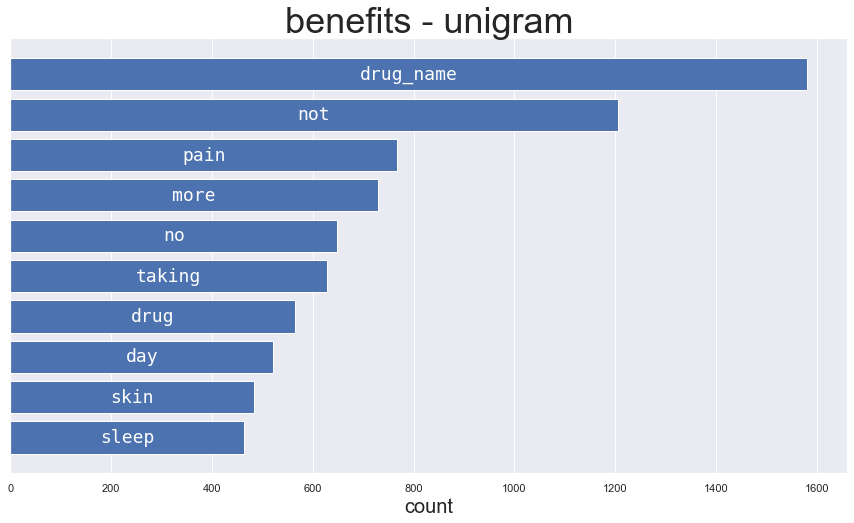

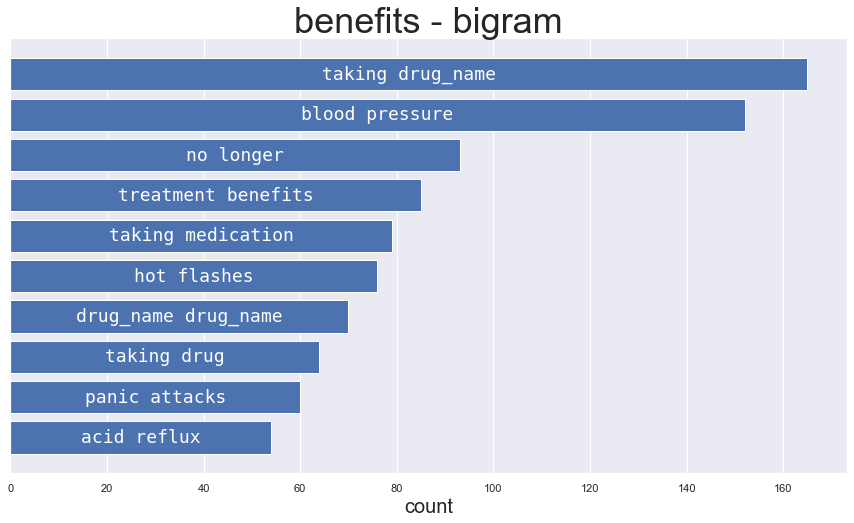

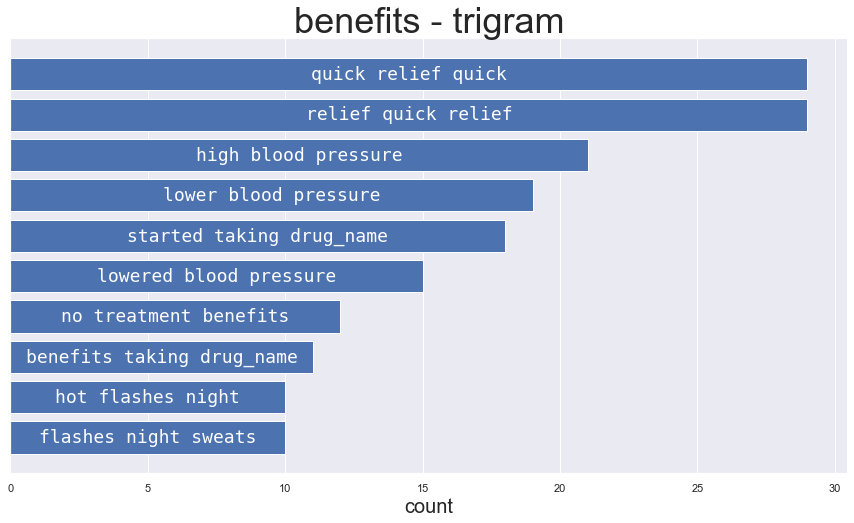

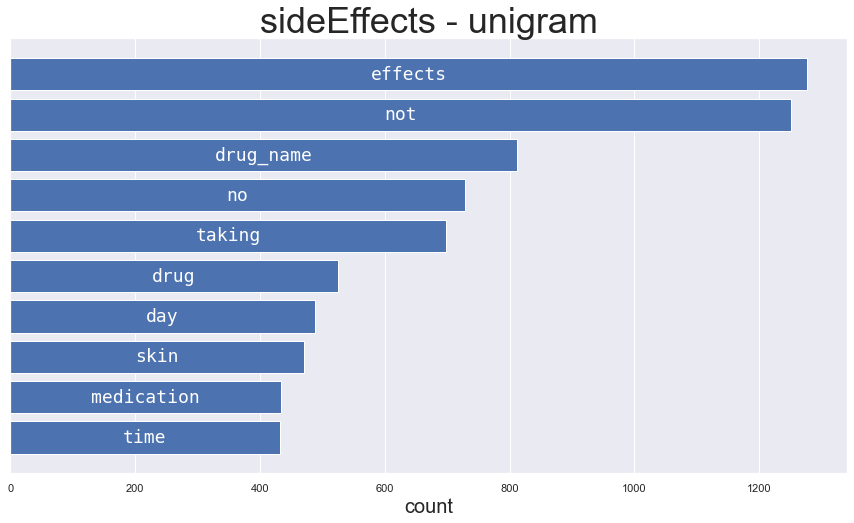

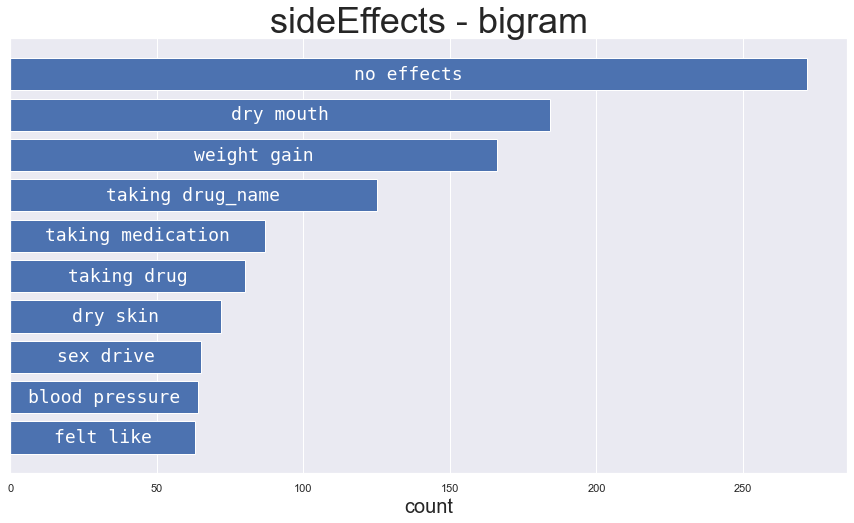

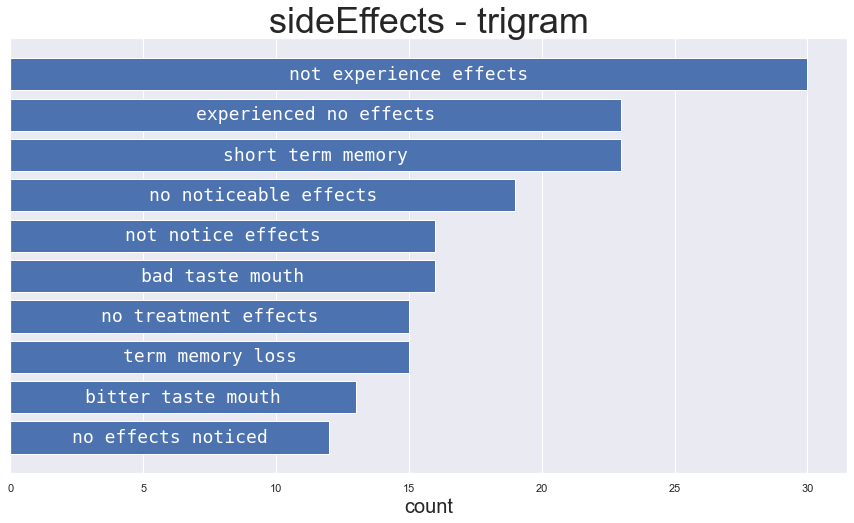

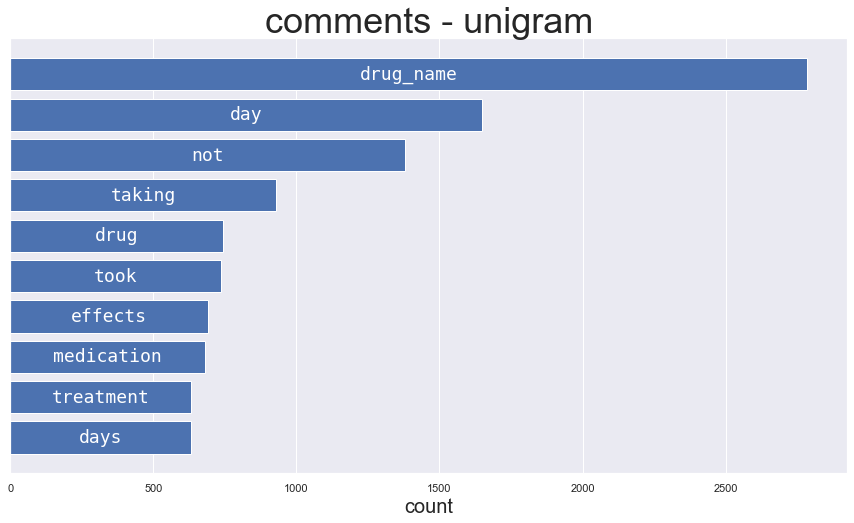

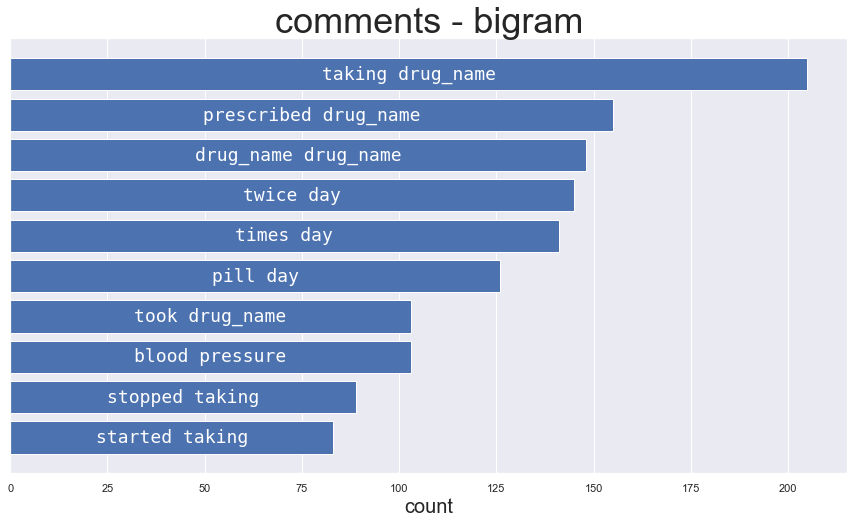

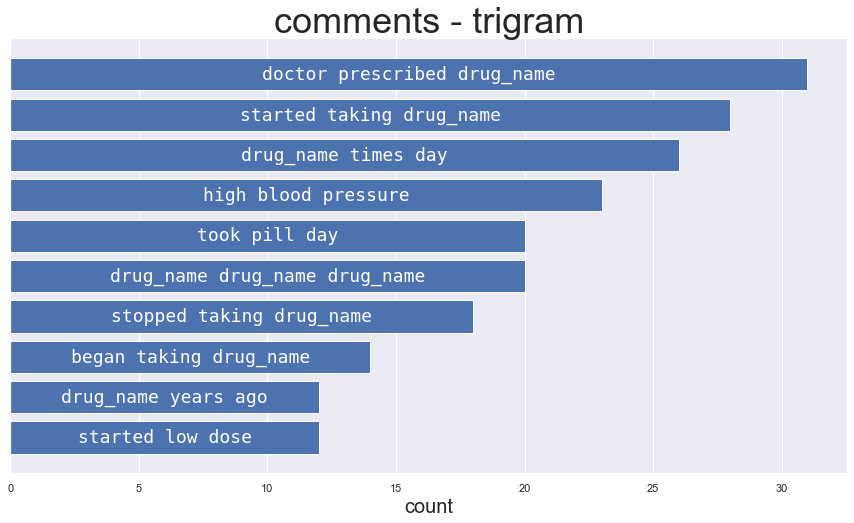

In [14]:
df_ngrams = pd.DataFrame(ngrams_common_10, columns =['benefits', 'sideEffects', 'comments', 'all'], index=['unigram', 'bigram', 'trigram', 'mixed_1-3'])
df_ngrams = df_ngrams.drop('mixed_1-3', axis=0)

def create_plot(df, column_name):
    df_column = df[column_name]
    for index, value in df_column.iteritems():
        fig, ax = plt.subplots(figsize=[15,8])       
        data=list(zip(*value))
        x_val = list(data[0])
        y_val = list(data[1])        
        hbars=plt.barh(x_val, y_val)
        ax.invert_yaxis()
        ax.yaxis.set_visible(False)
        ax.set_xlabel('count', fontsize=20)
        ax.set_title(f'{column_name} - {index}', fontsize=36)
        ax.bar_label(hbars, labels=x_val, color = 'white', label_type='center', fontsize=18, fontname='monospace')
        plt.show()

create_plot(df_ngrams,'benefits')
create_plot(df_ngrams,'sideEffects')
create_plot(df_ngrams,'comments')

##### 2. create word clouds

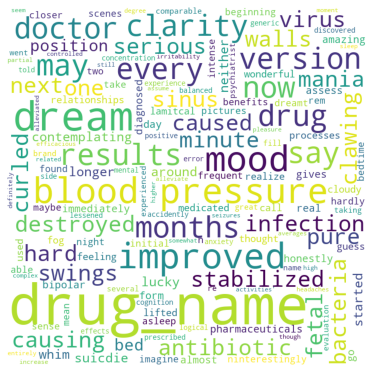

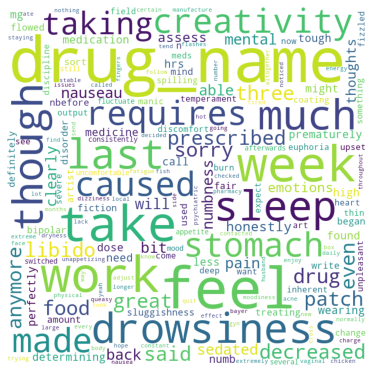

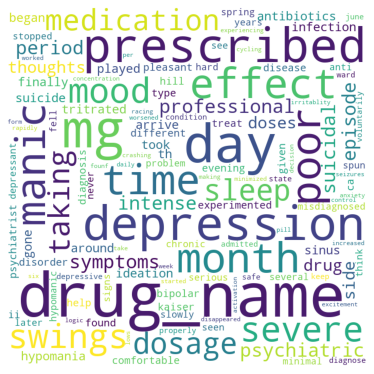

In [15]:
create_word_cloud(df_no_drugs, 'benefitsReview')
create_word_cloud(df_no_drugs, 'sideEffectsReview')
create_word_cloud(df_no_drugs, 'commentsReview')

##### 3. Create top tf_idfs (bigram_idf due to result of ML)

In [493]:
print(bows_2[-1]) # all


df_idf = get_tf_idf(bows_2, True)
df_sum_idf = pd.DataFrame(df_idf.sum(axis=0), columns=['sum'])
df_sum_idf =df_sum_idf.sort_values(by='sum', ascending=False)
df_sum_idf[2:12]

(CountVectorizer(max_features=10000, ngram_range=(2, 2),
                stop_words={'a', 'about', 'above', 'across', 'after',
                            'afterwards', 'again', 'against', 'ain', 'all',
                            'almost', 'alone', 'along', 'already', 'also',
                            'although', 'always', 'am', 'among', 'amongst',
                            'amoungst', 'amount', 'an', 'and', 'another', 'any',
                            'anyhow', 'anyone', 'anything', 'anyway', ...}), <4082x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 65798 stored elements in Compressed Sparse Row format>)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,sum
blood pressure,42.121983
taking medication,30.815807
weight gain,30.109834
drug_name drug_name,29.871144
twice day,27.962175
taking drug,27.429106
prescribed drug_name,27.391020
dry mouth,26.863090
times day,25.464250
no longer,24.949198


In [500]:
df_sum_idf = pd.DataFrame(df_idf.sum(axis=0), columns=['sum'])
df_sum_idf =df_sum_idf.sort_values(by='sum', ascending=False)
df_top_bigram = df_sum_idf[2:12]
df_top_bigram.index.names = ['bigram']
df_top_bigram = df_top_bigram.rename(columns={'sum':'sum_idf'})
df_top_bigram

,sum_idf
bigram,
blood pressure,42.121983
taking medication,30.815807
weight gain,30.109834
drug_name drug_name,29.871144
twice day,27.962175
taking drug,27.429106
prescribed drug_name,27.391020
dry mouth,26.863090
times day,25.464250


##### 4. Sentiments

Hypothesis: The polarity and subjectivity of the reviews may be correlated with the final Rating, effectiveness score and sideEffects score

Method: The TextBlob sentiment model was used to get polarity and subjectivity. Polarity is scored as [-1, 1] where those closer to -1 or 1 are extremely negative or extremely positive, respectively. Subjectivity is scored [0, 1] where those closer to 1 are highly opnionated while closer to 0 are more factual.

In [448]:
df_sentimentx = df_no_drugs.copy()
for column in column_reviews:   
    df_sentimentx = get_sentiments(df_sentimentx, column)

print(df_sentimentx.head())

     urlDrugName                                     benefitsReview  \
1366      biaxin  the antibiotic may have destroyed bacteria cau...   
3724    lamictal  drug_name stabilized my serious mood swings. o...   
3824    depakene  initial benefits were comparable to the brand ...   
969      sarafem  it controlls my mood swings. it helps me think...   
696     accutane  within one week of treatment superficial acne ...   

                                      sideEffectsReview  \
1366                      some back pain, some nauseau.   
3724  drowsiness, a bit of mental numbness. if you t...   
3824  drug_name has a very thin coating, which cause...   
969             i didnt really notice any side effects.   
696   side effects included moderate to severe dry s...   

                                         commentsReview  \
1366  took the antibiotics for  days. sinus infectio...   
3724  severe mood swings between hypomania and depre...   
3824  drug_name was prescribed to me by a

In [458]:
#df_sentimentx = df_sentimentx.drop(columns=['benefitsReview', 'sideEffectsReview', 'commentsReview', 'allReviews'])
df_sentimentx[['rating', 'effectiveness', 'sideEffects']] = df_num[['rating', 'effectiveness', 'sideEffects']]
df_sentimentx.head()

,urlDrugName,polarity_benefitsReview,subjectivity_benefitsReview,polarity_sideEffectsReview,subjectivity_sideEffectsReview,polarity_commentsReview,subjectivity_commentsReview,polarity_allReviews,subjectivity_allReviews,rating,effectiveness,sideEffects
1366,biaxin,-0.291667,0.541667,0.000000,0.000000,0.000000,0.000000,-0.145833,0.270833,9,4,2
3724,lamictal,0.254008,0.616944,0.188497,0.518529,0.140000,0.600000,0.208502,0.569437,9,5,2
3824,depakene,0.219697,0.307828,-0.225440,0.658791,-0.039951,0.472794,-0.041862,0.496724,4,3,4
969,sarafem,0.351439,0.630000,0.200000,0.200000,0.500000,0.700000,0.384133,0.605556,10,5,1
696,accutane,0.104830,0.554261,-0.022222,0.450000,0.750000,0.950000,0.126831,0.561174,10,5,2


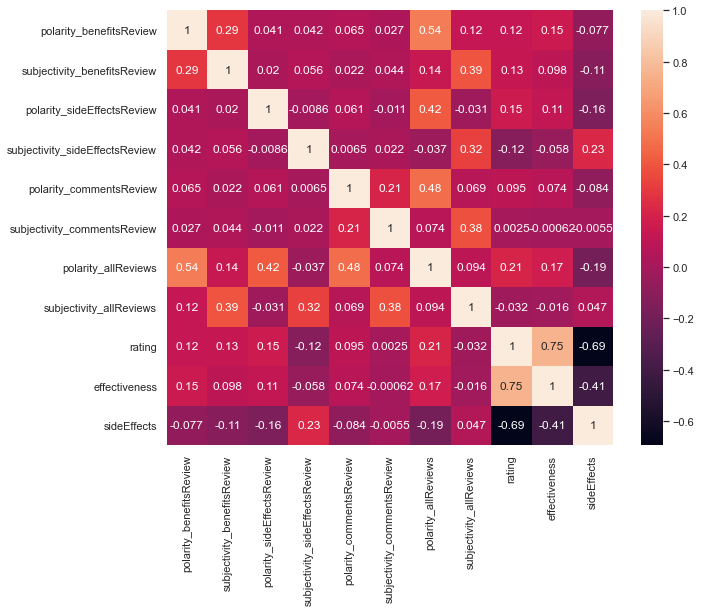

In [459]:
def create_correlation_charts(df_corr):
    sns.heatmap(df_corr, annot=True)
    plt.show()

df_corr = df_sentimentx.corr()
create_correlation_charts(df_corr)

Polarity and Subjectivity of all kinds of reviews have low correlation with Rating, effectiveness nor sideEffects. 
Preliminary ML runs do not show increased performance with addition of sentiments. The low correlation supports this initial findings.

Because of the low correlation and initial ML run, sentiments is not included in the final report.

# Machine learning

##### Functions for ML

* Get index for text because it is removed during countvectorizer

In [378]:
df_text = df_num.drop(['rating', 'effectiveness', 'sideEffects', 'condition'], axis=1)
df_text_index = df_text.reset_index()           # orig index
df_text_index = df_text_index[['index']]
df_text_index = df_text_index.rename(columns={'index': 'index_o'})
df_text_index.head(2)

,index_o
0,1366
1,3724


* Merge score & reviews, and scores, sentiments & reviews

In [ ]:
def create_X_text(bows, df_to_merge=None):                       # optimize code one iteration should be tf--> score+ text, score+sent+text, idf--> score+ text, score+sent+text,
    df_tf = get_tf_idf(bows, False)
    df_idf = get_tf_idf(bows, True)

    if df_to_merge is None:
        df_tf = df_tf.merge(df_text_index, left_index=True, right_index=True)  
        df_idf = df_idf.merge(df_text_index, left_index=True, right_index=True)

    if df_to_merge is not None:
        df_tf = df_to_merge.merge(df_tf, left_index=True, right_index=True)                                     
        df_idf = df_to_merge.merge(df_idf, left_index=True, right_index=True)   

    df_tf = df_tf.set_index('index_o')                          # to have same index with rating
    df_idf = df_idf.set_index('index_o')

    return df_tf, df_idf

* Functions to get fit and predict multiple models in regression and classification

In [ ]:
def get_regression(model, X_train, y_train, X_test, y_test):
    mdl = model
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

def get_classification(model, X_train, y_train, X_test, y_test):
    mdl = model
    try:
        mdl.fit(X_train, y_train.values.ravel())
        y_pred = mdl.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f_report = classification_report(y_test, y_pred)
        return accuracy, f_report
    except ValueError as e:                                                 # negative value with sentiments, not allowed in MNB
        print(f'{e} Maybe model not compatible, model skipped')
        pass

regressions = [
            LinearRegression(), 
            KNeighborsRegressor(n_neighbors=3),
            KNeighborsRegressor(n_neighbors=5), 
            KNeighborsRegressor(n_neighbors=15), 
            KNeighborsRegressor(n_neighbors=19)]
            
classifications = [
    LogisticRegression(), 
    KNeighborsClassifier(), 
    SVC(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    MultinomialNB()]



* Function to run all models

In [ ]:
def run_models(name, X, y, lst_reg, lst_class):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75)
    try:
        for model in regressions:
            mae, mse, rmse, r2 = get_regression(model, X_train, y_train, X_test, y_test)
            lst_reg.append([name, model, mae, mse, rmse, r2])
        
        for model in classifications:
            acc, report = get_classification(model, X_train, y_train, X_test, y_test)
            lst_class.append([name, model, acc])
    except TypeError as e:
        print(f'{e}')
        pass


### A. Prepare y and X's

y = rating (fixed) <br>
X: scores, scores+sentiment, scores+reviews, scores+reviews+sentiment, text

1. Create y: df for rating, as y data in model fitting

In [172]:
y = df_num[['rating']]                     # remove old index
print(y.shape)
y.head(2)

(4082, 1)


,rating
1366,9
3724,9


2. Create Scores df, consisting of numerical data

In [177]:
df_score = df_num[['effectiveness', 'sideEffects']]
df_score = df_score.reset_index()                           # remember to set_index to index later
print(df_score.shape)
df_score.head(2)                    

(4082, 3)


,index,effectiveness,sideEffects
0,1366,4,2
1,3724,5,2


3. Create features from sentiment analysis from Reviews (no longer included in the models)

In [178]:

df_sentiment1 = df_sentiment.reset_index()
df_score_sent = df_score.merge(df_sentiment1, on=['index'])

print(df_sentiment1.head())
print(df_score_sent.head())
df_score_sent.shape

   index  polarity  subjectivity
0   1366 -0.145833      0.270833
1   3724  0.208502      0.569437
2   3824 -0.041862      0.496724
3    969  0.384133      0.605556
4    696  0.126831      0.561174
   index  effectiveness  sideEffects  polarity  subjectivity
0   1366              4            2 -0.145833      0.270833
1   3724              5            2  0.208502      0.569437
2   3824              3            4 -0.041862      0.496724
3    969              5            1  0.384133      0.605556
4    696              5            2  0.126831      0.561174


(4082, 5)

In [359]:
train_tf, train_idf = create_X_text(bows_m)
#train_tf, train_idf = create_X_text(bows_m, df_score_sent)
#print(train_tf.head())
#train_tf.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      index
0      1366
1      3724
2      3824
3       969
4       696
...     ...
4077   1039
4078   3281
4079   1664
4080   2621
4081   2748

[4082 rows x 1 columns]


## Model fitting and prediction

In [460]:
df_score_t = df_score.rename(columns={'index': 'index_o'})
#df_score_sent_t = df_score_sent.rename(columns={'index': 'index_o'})

In [461]:
# lists to hold run model output then to create df
list_regression_perf = []
list_classification_perf = [] 

1. Run score and sentiment, and score and sentiment

In [462]:
df_score_X = df_score.set_index('index')                        # set_index to be compatible with y
#df_score_sent_X = df_score_sent.set_index('index')

In [463]:
run_models('score', df_score_X, y, list_regression_perf, list_classification_perf)
#run_models('score_sent', df_score_sent_X, y, list_regression_perf, list_classification_perf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

2. Run text only

In [464]:
for name, bow in bows_all.items():
    df_tf, df_idf = create_X_text(bow)
    run_models(name+'_tf', df_tf, y, list_regression_perf, list_classification_perf)
    run_models(name+'_idf', df_idf, y, list_regression_perf, list_classification_perf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Pre

3. Run text with scores

In [465]:
for name, bow in bows_all.items():
    df_tf, df_idf = create_X_text(bow, df_score_t)
    run_models(name+'_tf_score', df_tf, y, list_regression_perf, list_classification_perf)
    run_models(name+'_idf_score', df_idf, y, list_regression_perf, list_classification_perf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

4. Create data frame for performace results and show 10 best models based on r2 (regression) or accuracy (clssification)

In [466]:
df_regression_perf  = pd.DataFrame(list_regression_perf, columns=['Name', 'Model', 'MAE', 'MSE', 'RMSE', 'r2' ])
df_regression_perf =df_regression_perf.sort_values(by='r2', ascending=False)
print(df_regression_perf.shape)
df_regression_perf[:10]


(102, 6)


,Name,Model,MAE,MSE,RMSE,r2
76,bigram_idf_score,KNeighborsRegressor(n_neighbors=19),0.997423,1.939177,1.392543,0.767526
64,unigram_idf_score,KNeighborsRegressor(n_neighbors=19),0.987374,1.941177,1.393261,0.767286
58,unigram_tf_score,KNeighborsRegressor(n_neighbors=19),0.993043,1.946189,1.395059,0.766685
4,score,KNeighborsRegressor(n_neighbors=19),0.997874,1.948979,1.396058,0.766351
94,poylgram_tf_score,KNeighborsRegressor(n_neighbors=19),0.992785,1.950908,1.396749,0.766120
3,score,KNeighborsRegressor(n_neighbors=15),1.005549,1.953994,1.397853,0.765750
100,poylgram_idf_score,KNeighborsRegressor(n_neighbors=19),0.993107,1.955509,1.398395,0.765568
63,unigram_idf_score,KNeighborsRegressor(n_neighbors=15),0.987842,1.957764,1.399201,0.765298
82,trigram_tf_score,KNeighborsRegressor(n_neighbors=19),1.006120,1.961361,1.400486,0.764866
88,trigram_idf_score,KNeighborsRegressor(n_neighbors=19),1.007859,1.964030,1.401438,0.764547


In [467]:
df_classification_perf = pd.DataFrame(list_classification_perf, columns=['Name', 'Model', 'Accuracy'])
df_classification_perf =df_classification_perf.sort_values(by='Accuracy', ascending=False)
print(df_classification_perf.shape)
df_classification_perf[:10]

(102, 3)


,Name,Model,Accuracy
2,score,SVC(),0.461444
92,poylgram_tf_score,SVC(),0.449204
98,poylgram_idf_score,SVC(),0.449204
56,unigram_tf_score,SVC(),0.449204
62,unigram_idf_score,SVC(),0.449204
68,bigram_tf_score,SVC(),0.449204
74,bigram_idf_score,SVC(),0.449204
86,trigram_idf_score,SVC(),0.447980
80,trigram_tf_score,SVC(),0.447980
3,score,DecisionTreeClassifier(),0.439412


In [502]:
print('Regression output (rows, columns):', df_regression_perf.shape)
print('Classification output (rows, columns):', df_classification_perf.shape)

Regression output (rows, columns): (102, 6)
Classification output (rows, columns): (102, 3)


4. Create plots

<ipython-input-468-3a4a4824e178>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['Name_Model']= df_top.Name.str.cat(df_top.Model.astype(str))


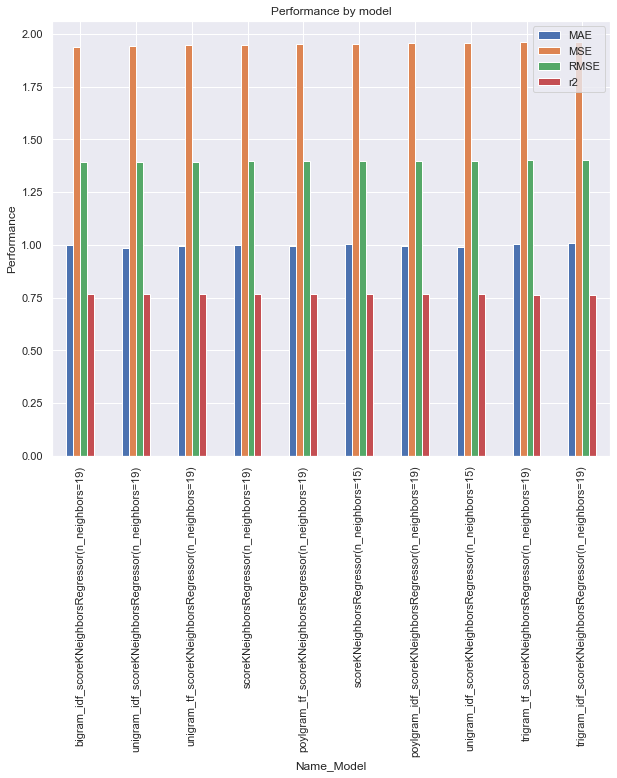

In [468]:
df_top = df_regression_perf[:10]

df_top['Name_Model']= df_top.Name.str.cat(df_top.Model.astype(str))

plt.rcParams["figure.figsize"] = (10,8)

bar = df_top.plot(x='Name_Model', kind='bar', stacked=False, title='Top Model Performances' )

bar.set_ylabel('Performance')
bar.set_title('Performance by model')
bar.legend()

plt.show()

<ipython-input-469-bce2bd73c800>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['Name_Model']= df_top.Name.str.cat(df_top.Model.astype(str))


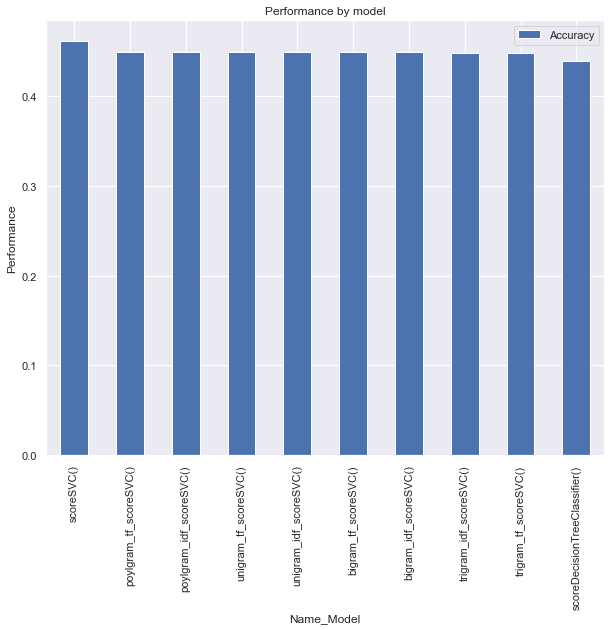

In [469]:
df_top = df_classification_perf[:10]

df_top['Name_Model']= df_top.Name.str.cat(df_top.Model.astype(str))

plt.rcParams["figure.figsize"] = (10,8)

bar = df_top.plot(x='Name_Model', kind='bar', stacked=False, title='Top Model Performances' )

bar.set_ylabel('Performance')
bar.set_title('Performance by model')
bar.legend()

plt.show()

### Try other parameters for best model

In [470]:
#acc, report = get_classification(RandomForestClassifier(n_estimators=150, max_depth=750), X_train, y_train, X_test, y_test)
#print(acc, report)

##### Feature importance **none for KNN

In [471]:
clf = RandomForestClassifier()
clf.fit(df_score_X, y)
fi = clf.feature_importances_
fi

<ipython-input-471-e06a77d570bd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(df_score_X, y)


array([0.55879778, 0.44120222])

In [472]:
clf = KNeighborsRegressor(n_neighbors=19)
clf.fit(df_tf, y)
importance = clf.n_samples_fit_
#data= pd.DataFrame(importance[0], index = df_tf.columns)
print(importance)
#print(list(zip(feature, importance)))
#for i, v in enumerate(importance):
#    print(f'Feature: {i}, Score: {v}')

4082


In [473]:
data = data.sort_values(by=0, ascending=False)
data[:20]

,0
label,13.740226
initally,13.230552
sample,12.583034
altogether,12.124616
rd,12.118913
chemical,12.033576
hours needed,11.820985
far no,11.672463
pain heart,11.524136
instantly,11.466003


##### Saving the model

In [486]:
import pickle

In [487]:
df_bigrams_score_tf, _ = create_X_text(bows_2, df_score_t)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [489]:
model = KNeighborsRegressor(n_neighbors=19)
model.fit(df_bigrams_score_tf, y)
filename = 'KNNregressor_19.sav'
with open(filename, 'wb') as f:
    pickle.dump(model,f)

In [490]:
with open(filename, 'rb') as f_in:
    modelx = pickle.load(f_in)

print(type(modelx))

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>


# EXTRA

In [485]:
df_rating = df_num.copy()
df_rating = df_rating.groupby(by='rating').agg({'benefitsReview':['sum'], 'sideEffectsReview':['sum'], 'commentsReview': ['sum'], 'effectiveness': ['mean'], 'sideEffects': ['mean']})
df_rating.head()

,benefitsReview,sideEffectsReview,commentsReview,effectiveness,sideEffects
,sum,sum,sum,mean,mean
rating,,,,,
1,the presumed benefits were to help with a seve...,here we go.the initial effect would be dry mou...,family doctor initially prescribed wellbutin b...,2.095465,4.150358
2,By the end of the 10-day treatment I felt bett...,I felt no significant side effects - perhaps s...,Basically the treatment did not seem to work. ...,2.296296,3.451852
3,some pain relief recieved minimized pain when ...,signigicant swelling of hands and feet so sign...,I started on 50mg twice aday with out any pain...,2.713542,3.265625
4,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...,3.034247,3.075342
5,The xanax would act as a downer. It would calm...,As I explained above. Addiction and drowsiness...,Once a day preferably at bedtime but if a situ...,3.393665,2.773756
